#  Nibelungenlied and Völsunga saga

Not only do the medieval Germanic people share a common ancestor concerning their languages, but they also have a common hero celebrated in several stories (poems, sagas).

* **Völsunga saga** (*saga* written in Old Norse around the XIII century) 
* **Nibelungenlied** (poem written in Middle High German around the XII century)
* the heroic lays of the **Poetic Edda** (poems written in Old Norse like **Grípisspá**, **Reginsmál**, **Fáfnismál**, **Sigrdrífumál**)

Characters in such stories look similar. It would be insteresting to analyse how much they look alike. Are the characters' nouns related? Do the characters have similar relationships with each other. 


From a statistical point of view, we can set a null hypothesis: "Characters' relationships with each other look alike in **Völsunga saga** and in **Nibelungenlied**" and an alternative hypothesis: "Characters' relationships with each other differ in **Völsunga saga** and in **Nibelungenlied**"


In other words, we will study in what extent **Völsunga saga** and **Nibelungenlied** differ.



## 1. Loading texts

### 1.1 Völsunga saga

#### 1.1.1 Reading the text

Import the code to load the text.

In [1]:
import norsecorpus.reader as ncr

See which texts are available.

In [2]:
available_texts = ncr.get_available_texts()
print(available_texts.keys())

dict_keys(['volsunga.xml'])


Load the selected text.

In [3]:
volsunga_saga = ncr.read_tei_words(available_texts["volsunga.xml"])

Check what was loaded.

In [4]:
print(volsunga_saga[0][0][0])

['Hér', 'hefr', 'upp', 'ok', 'segir', 'frá', 'þeim', 'manni', ',', 'er', 'Sigi', 'er', 'nefndr', 'ok', 'kallaðr', ',', 'at', 'héti', 'sonr', 'Óðins', '.']


We can see that the imported has a structure. 

Medival copists wrote the text without structure [see the original manuscript](https://handrit.is/en/manuscript/view/AM02-0006). The text structure was made later by philologists.

Text => chapters. Chapter => paragraphs. Paragraph => sentences. Sentence => words. Word => character.


Text: `volsunga_saga`

In [5]:
# print(volsunga_saga)

Chapter: `volsunga_saga[i_chapter]`

In [6]:
# print(volsunga_saga[0])

Paragraph: `volsunga_saga[i_chapter][j_paragraph]`

In [7]:
# print(volsunga_saga[0][0])

Sentence: `volsunga_saga[i_chapter][j_paragraph][k_sentence]`

In [8]:
# print(volsunga_saga[0][0][0])

Word (or more precisely token): `volsunga_saga[i_chapter][j_paragraph][k_sentence][l_token]`

In [9]:
print(volsunga_saga[0][0][0][0])

Hér


-----------------------------------
This is an ideal case where we have available code to read the structure of a text. Most of the time, it is necessary to:
- retrieve the text from a source,
- clean the text
- give a structure to the text (chapter, paragraph, sentence, word).

#### 1.1.2 Remove redundant information

Removal of stop words (words which appear in all kinds of texts)

In [10]:
from cltk.stop.old_norse.stops import STOPS_LIST

In [11]:
# {word for word in capital_words if word.lower() not in STOPS_LIST}

In [12]:
STOPS_LIST[10:20]

['mjök', 'ór', 'áðr', 'saman', 'inn', 'undir', 'heldr', 'brott', 'enn', 'niðr']

It is often needed to remove stop words because they cannot discriminate 

### 1.2 Loading Nieblungenlied (Augburg's corpus)

We import the functions to read the Nibelungenlied

In [13]:
import sigurd.nib_augsburg.nib_reader as nibaugr

`nibaugr.MAIN_LINKS` is the list of links to the different manuscription transcription of Nibelungenlied. The link is also the pointer to the stored text.

In [14]:
nibaugr.MAIN_LINKS[0]

'https://www.hs-augsburg.de/~harsch/germanica/Chronologie/12Jh/Nibelungen/nib_c_00.html'

`nibaugr.read_tei` extracts the content from a TEI-compliant XML file.

In [15]:
nibelungenlied_aug = nibaugr.read_tei(nibaugr.MAIN_LINKS[0])

(Explain why it is relevant to remove stop words from texts.) 

Less resourced languages often do not have many annotations and a stop word list is not always available. CLTK provides a class to extract stop words according to some criteria.

In [16]:
from cltk.stop import stop

In [17]:
mhg_stop_list = stop.BaseCorpusStoplist()
string_nibelungenlied_aug = [" ".join([" ".join(long_line) for long_line in chapter]) 
                                       for chapter in nibelungenlied_aug]
# mhg_stop_list.build_stoplist(string_nibelungenlied_aug)

In [18]:
from cltk.stop.middle_high_german.stops import STOPS_LIST

In [19]:
STOPS_LIST[:20]

['abe',
 'aber',
 'al',
 'alle',
 'allen',
 'aller',
 'alleȥ',
 'als',
 'alse',
 'alsô',
 'an',
 'ander',
 'andern',
 'anders',
 'ane',
 'âne',
 'beide',
 'besten',
 'bin',
 'bî']

In [20]:
"von" in STOPS_LIST

True

In [21]:
nibelungenlied_aug[0][:10]

[['UNS IST> In alten', 'mæren wnders vil geseit'],
 ['von heleden lobebæren', 'von grozer arebeit'],
 ['von frevde vn– hochgeciten', 'von weinen vn– klagen'],
 ['von kvner recken striten', 'mvget ir nv wnder horen sagen'],
 ['Ez whs <inBvregonden>', 'ein vil edel magedin'],
 ['daz in allen landen', 'niht schoners mohte sin'],
 ['Chriemhilt geheizen', 'div wart ein schone wip'],
 ['dar vmbe mvsin degene', 'vil verliesen den lip'],
 ['Ir pflagen dri kunige', 'edel un– rich'],
 ['Gunther un– Gernot', 'die rechen lobelich']]

In [22]:
[[[word for word in half_line.split(" ") if word.lower() not in STOPS_LIST] for half_line in long_line] for long_line in nibelungenlied_aug[0][:10]]

[[['IST>', 'alten'], ['mæren', 'wnders', 'geseit']],
 [['heleden', 'lobebæren'], ['grozer', 'arebeit']],
 [['frevde', 'vn–', 'hochgeciten'], ['weinen', 'vn–', 'klagen']],
 [['kvner', 'recken', 'striten'], ['mvget', 'nv', 'wnder', 'horen', 'sagen']],
 [['whs', '<inBvregonden>'], ['edel', 'magedin']],
 [['landen'], ['schoners', 'mohte', 'sin']],
 [['Chriemhilt', 'geheizen'], ['div', 'schone', 'wip']],
 [['vmbe', 'mvsin', 'degene'], ['verliesen', 'lip']],
 [['pflagen', 'dri', 'kunige'], ['edel', 'un–', 'rich']],
 [['Gunther', 'un–', 'Gernot'], ['rechen', 'lobelich']]]

## 2. Analysis of vocabulary

Which words are more likely associated to the main characters?

* See POS tagging and lemmatization.
* Adjectives are more that are associated to the main character are more likely to describe him.

The **method**:

- using the POS tagger to detect words which are adjectives,
- keep adjectives which are close to a main character,
- keep adjectives which are inflected according to the character.

The **main issue** is how words are spelled:

- the complete text is not normalized, whereas the POS tagger for Middle High German was trained on normalized annotated texts,
- the complete text is normalized, whereas the POS tagger for Old Norse was trained on Icelandic spelled texts.

This part has not been implemented.

## 3. Tracking characters 



### 3.1 Sigurðr's relationships

I chose to analyse Sigurðr's relationships because this character is present in the Nibelungenlied and in the Völsunga saga and is prominent. 

#### 3.1.1 Proper nouns extraction

The main feature of proper nouns is that... their first character is a capital character. (Just look at the name of your city, your first name and your family name).

However, the first word of every sentence has also this feature. The idea is to keep the words with this feature without the ones which are after a punctuation marking a new sentence/sequence. We hope that we don't lose many proper nouns. 

In [23]:
capital_words = set()
sentence_delimiters = "?!.:``''\""
all_words = [word for chapter in volsunga_saga for para in chapter for sentence in para for word in sentence]
for i in range(1, len(all_words)):
    if all_words[i-1][-1] not in sentence_delimiters and all_words[i] and all_words[i][0].isupper():
        capital_words.add(all_words[i])

In [24]:
# capital_words

We got proper nouns in the tex with their different attested inflections.

Some are humans, some are dwarves, some are gods.

In [25]:
from collections import defaultdict


def common_prefix(s1, s2):
    """
    >>> len_common_prefix("bonjour", "bonsoir")
    "bon"
    """
    len_1 = len(s1)
    len_2 = len(s2)
    min_1_2 = min(len_1, len_2)
    i = 0
    while i < min_1_2:
        if s1[i] != s2[i]:
            break
        i += 1
    return i, s1[:i]

def find_paradigms(words):
    common_words = defaultdict(set)
    for i, w1 in enumerate(words):
        for j in range(i+1, len(words)):
            common_words[w1].add(w1)
            w2 = words[j]
            len_1_2, cw_1_2 = common_prefix(w1, w2)
            if len(w1) + 2 < len(w2) or len(w2) + 2 < len(w1):
                pass
            elif(len(w1) <= len_1_2*1.4 and len(w2) <= len_1_2*1.4): #  (len_1_2 < 2 and len(w1) < 4 and len(w2) < 4) or 
                common_words[cw_1_2].add(w1)
                common_words[cw_1_2].add(w2)
    common_words = {common_word: common_words[common_word] for common_word in common_words 
                    if common_word not in [co for cw in common_words if cw != common_word for co in common_words[cw]]}    
    return common_words


proper_nouns_paradigms = find_paradigms(list(capital_words))

volsunga_characters = {inflected_form: proper_noun_paradigm for proper_noun_paradigm in proper_nouns_paradigms 
                       for inflected_form in proper_nouns_paradigms[proper_noun_paradigm]}

# print(len(proper_nouns_paradigms))
# print(proper_nouns_paradigms)
# print(volsunga_characters)

#### 3.1.2 Ego graph of Sigurðr

In [26]:
# From "Applied Text Analysis with Python"
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [27]:
def one_of_them_in(l1, l2):
    for i in l1:
        if i in l2:
            return True
    return False

In [28]:
def cooccurrence_vol(text, characters):
    possible_pairs = list(itertools.combinations(list(characters.keys()), 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for chapter in text:
        for para in chapter:
            for sent in para:
                for pair in possible_pairs:
                    if one_of_them_in(characters[pair[0]], sent) and one_of_them_in(characters[pair[1]], sent):
#                         cooccurring[(characters[pair[0]], characters[pair[1]])] += 1
                        cooccurring[pair] += 1
    return cooccurring

In [29]:
def cooccurrence_nib_aug(text, characters):
    possible_pairs = list(itertools.combinations(list(characters.keys()), 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for chapter in text:
#         for long_line in chapter:
            for pair in possible_pairs:
                if one_of_them_in(characters[pair[0]], " ".join([" ".join(long_line) for long_line in chapter])) and one_of_them_in(characters[pair[1]], " ".join([" ".join(long_line) for long_line in chapter])):
#                         cooccurring[(characters[pair[0]], characters[pair[1]])] += 1
                    cooccurring[pair] += 1
    return cooccurring

Variants of Völsung.

In [30]:
proper_nouns_paradigms['Völsung']

{'Völsung', 'Völsunga', 'Völsungar', 'Völsungi', 'Völsungr', 'Völsungs'}

- 'Völsungr': nominative singular
- 'Völsung': accusative singular
- 'Völsungi': dative singular
- 'Völsungs': genitive singular
- 'Völsungar': nominative and accusative plural
- 'Völsunga': genitive plural

c:\users\clems\pycharmprojects\comparison_sigurdr_siegfried\venv\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


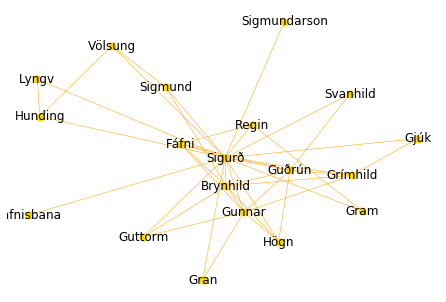

In [31]:
g_vol = nx.Graph()
g_vol.name = "Relationships of Sigurðr"
pairs = cooccurrence_vol(volsunga_saga, proper_nouns_paradigms)
for pair, weight in pairs.items():
    if weight > 1:
        g_vol.add_edge(pair[0], pair[1], weight=weight)
sigurdr = nx.ego_graph(g_vol, "Sigurð")
edges, weights = zip(*nx.get_edge_attributes(sigurdr, "weight").items())

pos = nx.spring_layout(sigurdr, k=0.5, iterations=40)
nx.draw(sigurdr, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

- Sigurðr is at the center of the graph. 
- We can see a close relationship between Sigurðr and Brynhildr, one of his lovers, and a more distant relationship with Gudrun.
- Ennemies of Sigurðr are Fafni (the dragon), Regin (Fafni's brother).
- Sigurðr's ancestors: Sigmund, Völsung
- A sword named Gram was used to kill Regin

#### 3.1.3 Ego graph of Guðrún

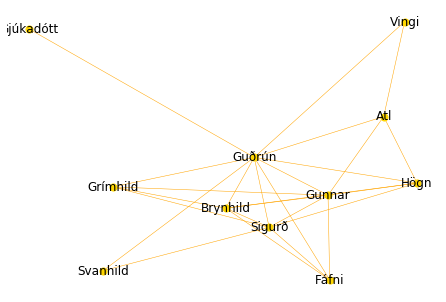

In [32]:
g_vol = nx.Graph()
g_vol.name = "Relationships of Guðrún"
pairs = cooccurrence_vol(volsunga_saga, proper_nouns_paradigms)
for pair, weight in pairs.items():
    if weight > 1:
        g_vol.add_edge(pair[0], pair[1], weight=weight)
gudrun = nx.ego_graph(g_vol, "Guðrún")
edges, weights = zip(*nx.get_edge_attributes(gudrun, "weight").items())

pos = nx.spring_layout(gudrun, k=0.5, iterations=40)
nx.draw(gudrun, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

### 3.2 Sigfried's relationships

#### 3.2.1 Proper nouns extraction

For this text, I extracted manually the places and the characters' names.

In [33]:
nib_names = nibaugr.read_names()

Variants of Brünhild in the manuscript C.

In [34]:
nib_names['Brünhild']

["Prvnh'",
 'Prvenhilde',
 'Privnhilde',
 'Prvnhilt',
 'Prvonhilde',
 'Prvnhilde',
 'Prunhilt',
 'Prunhilde']

#### 3.2.2 Ego graph of Siegfried

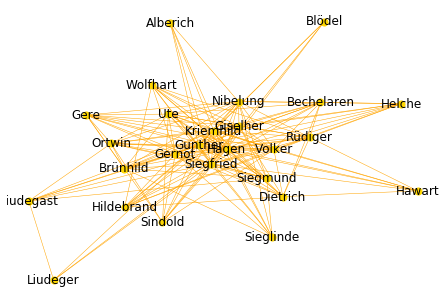

In [35]:
g_nib_aug = nx.Graph()
g_nib_aug.name = "Relationships of Siegfried"
pairs = cooccurrence_nib_aug(nibelungenlied_aug, nib_names)
for pair, weight in pairs.items():
    if weight > 2:
        g_nib_aug.add_edge(pair[0], pair[1], weight=weight)
        
siegfried = nx.ego_graph(g_nib_aug, "Siegfried")
edges, weights = zip(*nx.get_edge_attributes(siegfried, "weight").items())

pos = nx.spring_layout(siegfried, k=0.5, iterations=40)
nx.draw(siegfried, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

It is less visible here. It seems that there are more characters.

It has to be noted that Kriemhild and Gudrun are actually the same characters. Their names do not help recognize this fact, but they are both married with Siegfried/Sigurdr and 

#### 3.2.2 Ego graph of Kriemhild

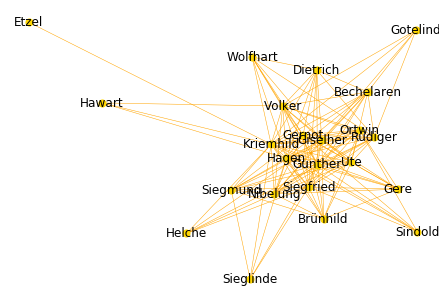

In [36]:
g_nib_aug = nx.Graph()
g_nib_aug.name = "Relationships of Kriemhild"
pairs = cooccurrence_nib_aug(nibelungenlied_aug, nib_names)
for pair, weight in pairs.items():
    if weight > 3:
        g_nib_aug.add_edge(pair[0], pair[1], weight=weight)
        
kriemhild = nx.ego_graph(g_nib_aug, "Kriemhild")
edges, weights = zip(*nx.get_edge_attributes(kriemhild, "weight").items())

pos = nx.spring_layout(kriemhild, k=0.5, iterations=40)
nx.draw(kriemhild, pos, node_color="gold", node_size=50, edgelist=edges, width=0.5, 
        edge_color="orange", with_labels=True, font_size=12)
plt.show()

## Conclusion

We could see similarities and differencies between two medival works written in two different but related languages.
If we know enough how our data are built, then it is possible to automate processes and analyze the outputs. 

-----------------------------
By Clément Besnier, CLTK contributor ([www.clementbesnier.fr](https://www.clementbesnier.fr/), [github](https://github.com/clemsciences), [twitter](https://twitter.com/clemsciences)).